# Loading th1 data models

### Table of contents

1. [**One-dimensional regression**](#1D)
2. [**Two-dimensional regression**](#2D)



In [1]:
%load_ext autoreload
%autoreload

import sys

sys.path.append("../../../GaussNeuro")
import gaussneuro as lib

sys.path.append("../fit/")
import th1

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np


import analyze_th1
import utils

/var/home/dl543/Documents/Learning/nonparametric-modulated-renewal/scripts/analysis/../../../GaussNeuro/gaussneuro/likelihoods/renewal.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
jax.config.update('jax_platform_name', 'cpu')
#jax.config.update("jax_enable_x64", True)

In [3]:
data_path = '../../data/th1/'
checkpoint_dir = '../checkpoint/'


seed = 123
rng = np.random.default_rng(seed)
prng_state = jr.PRNGKey(seed)
batch_size = 10000

In [4]:
### load dataset ###
session_name = 'Mouse28_140313_wake_isi5'
max_ISI_order = 4

select_fracs = [0.0, 0.5]
dataset_dict = th1.spikes_dataset(session_name, data_path, max_ISI_order, select_fracs)

test_select_fracs = [
    [0.5, 0.6], 
    [0.6, 0.7], 
    [0.7, 0.8], 
    [0.8, 0.9], 
    [0.9, 1.0], 
]
test_dataset_dicts = [
    th1.spikes_dataset(session_name, data_path, max_ISI_order, tf) for tf in test_select_fracs
]

In [5]:
# extra analysis: compare matern 12/32/53 combos for the ISI kernels, compare fixing warp tau and fixing negative mean amp

### names ###
reg_config_names = [
    'Mouse28_140313_wake_isi5ISI5sel0.0to0.5_isi4__nonparam_pp_gp-40-matern12-matern32-1000-n6._' + \
    'X[hd]_Z[]_freeze[obs_model0mean_amp]', 
    'Mouse28_140313_wake_isi5ISI5sel0.0to0.5_isi4__nonparam_pp_gp-40-matern12-matern32-1000-n2._' + \
    'X[hd]_Z[]_freeze[obs_model0log_warp_tau]', 
    'Mouse28_140313_wake_isi5ISI5sel0.0to0.5_isi4__nonparam_pp_gp-40-matern12-matern32-1000-n2._' + \
    'X[hd]_Z[]_freeze[]', 
    'Mouse28_140313_wake_isi5ISI5sel0.0to0.5_isi4__nonparam_pp_gp-40-matern32-matern32-1000-n6._' + \
    'X[hd]_Z[]_freeze[obs_model0mean_amp]', 
    'Mouse28_140313_wake_isi5ISI5sel0.0to0.5_isi4__nonparam_pp_gp-40-matern32-matern32-1000-n2._' + \
    'X[hd]_Z[]_freeze[obs_model0log_warp_tau]', 
    'Mouse28_140313_wake_isi5ISI5sel0.0to0.5_isi4__nonparam_pp_gp-40-matern32-matern32-1000-n2._' + \
    'X[hd]_Z[]_freeze[]', 
]

data_path = '../../data/th1/'
checkpoint_dir = '../checkpoint/'


seed = 123
rng = np.random.default_rng(seed)
prng_state = jr.PRNGKey(seed)
batch_size = 10000


In [ ]:
# extra plot: show metrics, show different cISIs at identical locations for comparison, tuning...
regression_dict = utils.evaluate_regression_fits(
    checkpoint_dir, reg_config_names, th1.observed_kernel_dict_induc_list, 
    dataset_dict, test_dataset_dicts, rng, prng_state
)

Analyzing regression for Mouse28_140313_wake_isi5ISI5sel0.0to0.5_isi4__nonparam_pp_gp-40-matern12-matern32-1000-n6._X[hd]_Z[]_freeze[obs_model0mean_amp]...
Training data...
Test data...


In [ ]:
import matplotlib.pyplot as plt
plt.style.use(['../plots/paper.mplstyle'])

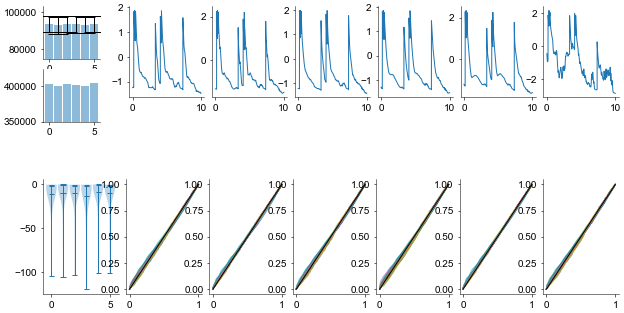

In [22]:
fig = plt.figure(figsize=(8, 4))

#fig.text(0.22, 1.05, 'repeatable trials', fontsize=12, ha='center')
#fig.text(0.78, 1.05, 'naturalistic behaviour', fontsize=12, ha='center')


### likelihoods ###
widths = [1]
heights = [1, 1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.6, 
                        left=0.0, right=0.1, wspace=0.1)

mdls = len(reg_config_names)
test_lls = np.array([regression_dict[n]['test_ells'] for n in reg_config_names])
train_lls = np.array([regression_dict[n]['train_ell'] for n in reg_config_names])

ax = fig.add_subplot(spec[0, 0])
means = test_lls.mean(-1)
sems = test_lls.std(-1) / np.sqrt(test_lls.shape[-1])
ax.bar(np.arange(mdls), means, yerr=sems, 
       align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylim(7.5 * 1e4)

ax = fig.add_subplot(spec[1, 0])
means = train_lls
ax.bar(np.arange(mdls), means, 
       align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylim(3.5 * 1e5)



widths = [1, 1, 1, 1, 1, 1]
heights = [1, 0.1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.6, 
                        left=0.15, right=1., hspace=0.3, wspace=0.1)

test_fold = 0
ne = 0
for en, n in enumerate(reg_config_names):
    pred_lint = regression_dict[n]['pred_log_intensities']
    pred_ts = regression_dict[n]['pred_ts']
    ax = fig.add_subplot(spec[0, en])
    ax.plot(pred_ts, pred_lint[test_fold][0, ne, :])
    #sts = regression_dict[n]['pred_spiketimes'][test_fold][ne]
    #ax = fig.add_subplot(spec[1, en])
    #for st in sts:
    #    ax.plot(st*np.ones(2), np.linspace(0, 1, 2))


### KS statistics ###
widths = [1, 1, 1, 1, 1, 1, 1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.4, bottom=0.0, 
                        left=0.0, right=1., wspace=0.1)

ax = fig.add_subplot(spec[0, 0])

mdls = len(reg_config_names[:])
p_vals = [regression_dict[n]['KS_p_value'] for n in reg_config_names[:]]
p_vals = [[v for v in d if v is not None] for d in p_vals]

ax.violinplot(
    list(np.log(p_vals)), list(range(mdls)), points=20, widths=0.9,
    showmeans=True, showextrema=True, showmedians=True, 
    bw_method='silverman', 
)
#ax.set_yscale('log')

for en, n in enumerate(reg_config_names):
    quantiles = regression_dict[n]['KS_quantiles']

    ax = fig.add_subplot(spec[0, en + 1])
    for n in range(len(quantiles)):
        if quantiles[n] is not None:
            ax.plot(np.linspace(0., 1., len(quantiles[n])), quantiles[n], alpha=0.7)
    ax.plot(np.linspace(0., 1., 100), np.linspace(0., 1., 100), c='k')






plt.show()